In [1]:
# Importation des bibliothèques
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import length , col, concat_ws, split, explode, count
from pyspark.ml.feature import Tokenizer,StopWordsRemover, CountVectorizer,IDF,StringIndexer, VectorAssembler
from pyspark.ml.linalg import Vector
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd
from cassandra.cluster import Cluster
from cassandra.query import dict_factory
import findspark
findspark.init('/home/vboxuser/spark-3.3.1-bin-hadoop3')

In [2]:
# Creation de la session Spark
spark = SparkSession.builder.appName('nlp').getOrCreate()

In [3]:
# Connexion à la base de données Cassandra
cluster=Cluster(['127.0.0.1'],port=9042)
# Connexion à la keyspace "mykeyspace1"
session= cluster.connect('mykeyspace1')
# Définition du type de dictionnaire pour les résultats
session.row_factory=dict_factory
# Exécution de la requête pour sélectionner toutes les lignes de la table "spam" 
rows=session.execute('select * from spam')
# Conversion des résultats en dataframe Pandas
df_pandas = pd.DataFrame(list(rows))
# Conversion du dataframe Pandas en dataframe Spark
data = spark.createDataFrame(df_pandas)
data.show()

+----+--------------------+
|  v1|                  v2|
+----+--------------------+
| ham|Go until jurong p...|
| ham|Ok lar... Joking ...|
|spam|Free entry in 2 a...|
| ham|U dun say so earl...|
| ham|Nah I don't think...|
|spam|FreeMsg Hey there...|
| ham|Even my brother i...|
| ham|As per your reque...|
|spam|WINNER!! As a val...|
|spam|Had your mobile 1...|
| ham|I'm gonna be home...|
|spam|SIX chances to wi...|
|spam|URGENT! You have ...|
| ham|I've been searchi...|
| ham|I HAVE A DATE ON ...|
|spam|XXXMobileMovieClu...|
| ham|Oh k...i'm watchi...|
| ham|Eh u remember how...|
| ham|Fine if that��s t...|
|spam|England v Macedon...|
+----+--------------------+
only showing top 20 rows



In [4]:
# Renomme les colonnes 'v1' et 'v2'
data = data.withColumnRenamed('v1','class').withColumnRenamed('v2','text')

In [5]:
data.show()

+-----+--------------------+
|class|                text|
+-----+--------------------+
|  ham|Go until jurong p...|
|  ham|Ok lar... Joking ...|
| spam|Free entry in 2 a...|
|  ham|U dun say so earl...|
|  ham|Nah I don't think...|
| spam|FreeMsg Hey there...|
|  ham|Even my brother i...|
|  ham|As per your reque...|
| spam|WINNER!! As a val...|
| spam|Had your mobile 1...|
|  ham|I'm gonna be home...|
| spam|SIX chances to wi...|
| spam|URGENT! You have ...|
|  ham|I've been searchi...|
|  ham|I HAVE A DATE ON ...|
| spam|XXXMobileMovieClu...|
|  ham|Oh k...i'm watchi...|
|  ham|Eh u remember how...|
|  ham|Fine if that��s t...|
| spam|England v Macedon...|
+-----+--------------------+
only showing top 20 rows



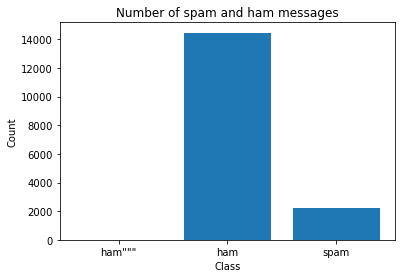

In [6]:
# Supprimer les lignes de data qui contiennent des valeurs manquantes
data = data.na.drop()

# Compter le nombre de messages spam et ham
counts = data.groupBy('class').agg(count('*').alias('count')).collect()

# Créer un graphique à barres
labels = [row['class'] for row in counts]
values = [row['count'] for row in counts]
plt.bar(labels, values)

# Définir le titre et les labels
plt.title('Number of spam and ham messages')
plt.xlabel('Class')
plt.ylabel('Count')

# Afficher le graphique
plt.show()

In [7]:
# Concaténer la colonne 'text' en une chaîne de caractères avec un délimiteur d'espace
data = data.withColumn('text_str', concat_ws(' ', 'text'))
# Divisez la colonne 'text_str' en un tableau de mots
data = data.withColumn('words', split('text_str', ' '))

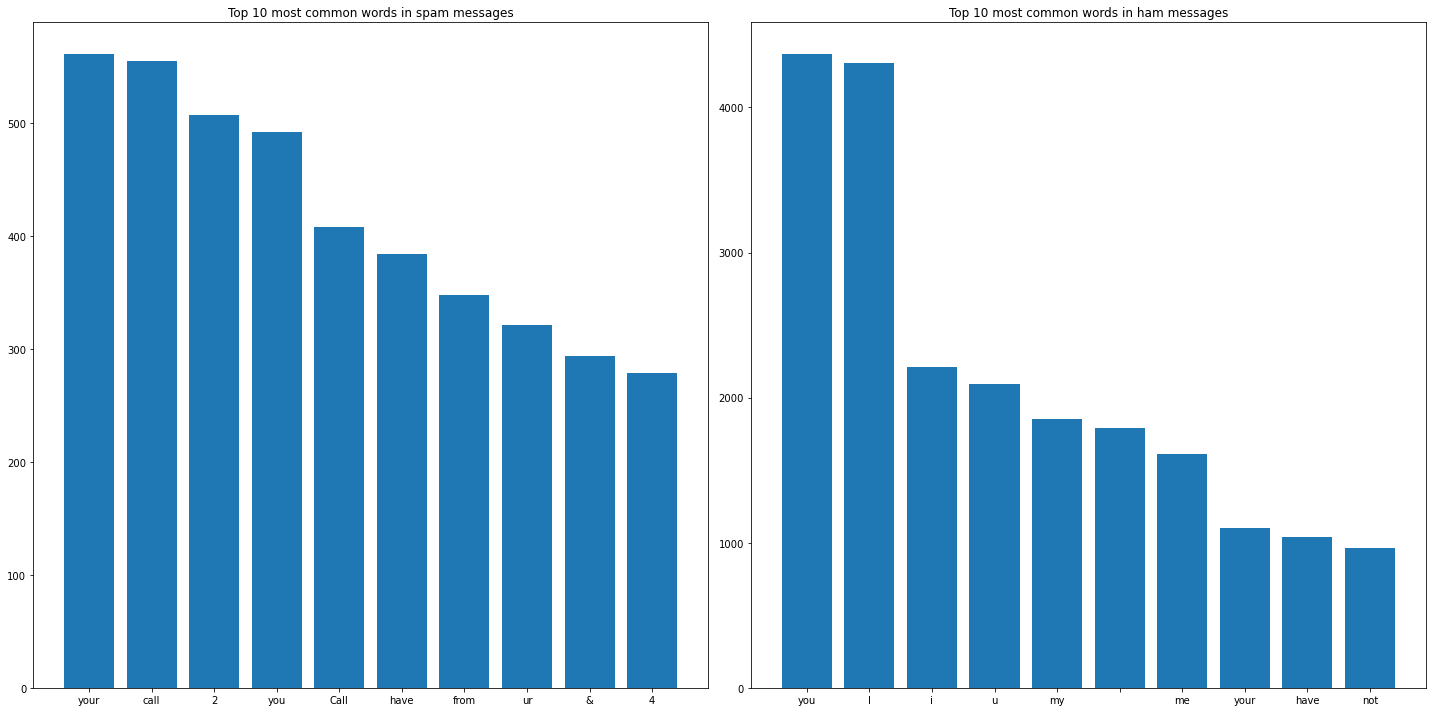

In [8]:
# Séparer la colonne 'text' en mots individuels
words = data.select('class', explode(split('text_str', ' ')).alias('word'))

# Compter l'occurrence de chaque mot par classe
word_counts = words.groupBy('class', 'word').agg(count('*').alias('count'))

# Filtrer les stop words
stop_words = ['a', 'an', 'the', 'is', 'in', 'to', 'and', 'that', 'of', 'it', 'for', 'with', 'on', 'at', 'by', 'this', 'be', 'or']
word_counts = word_counts.filter(~word_counts.word.isin(stop_words))

# Obtenir les 10 mots les plus courants pour les messages spam et ham
spam_words = word_counts.filter(word_counts['class'] == 'spam').orderBy('count', ascending=False).limit(10)
ham_words = word_counts.filter(word_counts['class'] == 'ham').orderBy('count', ascending=False).limit(10)

# Convertir les dataframes PySpark en dataframes Pandas pour le traçage
spam_words_pd = spam_words.toPandas()
ham_words_pd = ham_words.toPandas()

# Tracer les 10 mots les plus courants pour les messages de spam et de ham
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].bar(spam_words_pd['word'], spam_words_pd['count'])
axs[0].set_title('Top 10 most common words in spam messages')
axs[1].bar(ham_words_pd['word'], ham_words_pd['count'])
axs[1].set_title('Top 10 most common words in ham messages')
plt.tight_layout()
plt.show()

In [9]:
# Ajouter une nouvelle colonne appelée "length" au DataFrame "data"
data = data.withColumn('length',length(data['text']))

In [10]:
data.show()

+-----+--------------------+--------------------+--------------------+------+
|class|                text|            text_str|               words|length|
+-----+--------------------+--------------------+--------------------+------+
|  ham|Go until jurong p...|Go until jurong p...|[Go, until, juron...|   111|
|  ham|Ok lar... Joking ...|Ok lar... Joking ...|[Ok, lar..., Joki...|    29|
| spam|Free entry in 2 a...|Free entry in 2 a...|[Free, entry, in,...|   155|
|  ham|U dun say so earl...|U dun say so earl...|[U, dun, say, so,...|    49|
|  ham|Nah I don't think...|Nah I don't think...|[Nah, I, don't, t...|    61|
| spam|FreeMsg Hey there...|FreeMsg Hey there...|[FreeMsg, Hey, th...|   147|
|  ham|Even my brother i...|Even my brother i...|[Even, my, brothe...|    77|
|  ham|As per your reque...|As per your reque...|[As, per, your, r...|   160|
| spam|WINNER!! As a val...|WINNER!! As a val...|[WINNER!!, As, a,...|   157|
| spam|Had your mobile 1...|Had your mobile 1...|[Had, your, mob

In [11]:
# Supprimer les lignes qui contiennent 'ham""""' dans la colonne "class"
data = data.filter(~col("class").contains('ham"""'))

In [12]:
# Calculer la moyenne de chaque colonne
data.groupby('class').mean().show()

+-----+-----------------+
|class|      avg(length)|
+-----+-----------------+
|  ham| 70.8972621681416|
| spam|138.5069165551093|
+-----+-----------------+



In [12]:
# Création d'un tokenizer pour découper le texte en mots
tokenizer = Tokenizer(inputCol="text", outputCol="token_text")
# Création d'un filtre pour supprimer les stop words
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
# Création d'un vecteur de compte pour compter les occurrences de chaque mot
count_vec = CountVectorizer(inputCol='stop_tokens',outputCol='c_vec')
# Calcul de l'IDF pour pondérer les comptages de chaque mot
idf = IDF(inputCol="c_vec", outputCol="tf_idf")
# Conversion de la variable cible 'class' de catégorique (spam/ham) à numérique
ham_spam_to_num = StringIndexer(inputCol='class',outputCol='label')

In [13]:
# Combinez les fonctionnalités TF-IDF et la longueur du message
clean_up = VectorAssembler(inputCols=['tf_idf','length'],outputCol='features')

In [14]:
# Initialiser le modele
nb = NaiveBayes()

In [15]:
# Crée un pipeline
data_prep_pipe = Pipeline(stages=[ham_spam_to_num,tokenizer,stopremove,count_vec,idf,clean_up])

In [17]:
# Crée un modèle en ajustant le pipeline aux données d'entraînement
cleaner = data_prep_pipe.fit(data)

In [18]:
# Transformation des données en utilisant le Pipeline
clean_data = cleaner.transform(data)

In [19]:
# Sélectionner les colonnes 'label' et 'features' de l'ensemble de données nettoyé 'clean_data'
clean_data = clean_data.select(['label','features'])

In [20]:
clean_data.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(14028,[6,9,31,61...|
|  0.0|(14028,[0,23,293,...|
|  1.0|(14028,[2,12,19,2...|
|  0.0|(14028,[0,68,78,1...|
|  0.0|(14028,[36,132,30...|
|  1.0|(14028,[10,63,139...|
|  0.0|(14028,[10,50,106...|
|  0.0|(14028,[124,186,4...|
|  1.0|(14028,[1,45,115,...|
|  1.0|(14028,[0,1,12,26...|
|  0.0|(14028,[18,43,116...|
|  1.0|(14028,[7,15,37,8...|
|  1.0|(14028,[12,29,45,...|
|  0.0|(14028,[39,94,223...|
|  0.0|(14028,[542,1594,...|
|  1.0|(14028,[29,108,10...|
|  0.0|(14028,[80,216,44...|
|  0.0|(14028,[0,2,48,13...|
|  0.0|(14028,[0,73,102,...|
|  1.0|(14028,[4,29,32,5...|
+-----+--------------------+
only showing top 20 rows



In [21]:
# Découpe les données nettoyées en un ensemble d'entraînement (70%) et un ensemble de test (30%)
(training,testing) = clean_data.randomSplit([0.7,0.3])

In [22]:
# Entraîner le modèle de prédiction de spam
spam_predictor = nb.fit(training)

In [23]:
data.printSchema()

root
 |-- class: string (nullable = true)
 |-- text: string (nullable = true)
 |-- text_str: string (nullable = false)
 |-- words: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- length: integer (nullable = true)



In [24]:
# Faire des prédictions sur les données de test et les données d'entraînement
test_results = spam_predictor.transform(testing)
training_results = spam_predictor.transform(training)

In [25]:
test_results.show(100)
training_results.show(100)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(14028,[0,1,2,12,...|[-606.59122531528...|[1.0,1.7994141979...|       0.0|
|  0.0|(14028,[0,1,2,12,...|[-606.59122531528...|[1.0,1.7994141979...|       0.0|
|  0.0|(14028,[0,1,2,41,...|[-1022.3887794922...|[1.0,2.8182342184...|       0.0|
|  0.0|(14028,[0,1,5,14,...|[-958.74756455080...|[1.0,4.5173201784...|       0.0|
|  0.0|(14028,[0,1,5,20,...|[-788.41162439220...|[1.0,2.0253832407...|       0.0|
|  0.0|(14028,[0,1,6,7,9...|[-848.65928189423...|[1.0,2.3057455729...|       0.0|
|  0.0|(14028,[0,1,6,7,1...|[-1132.1333002635...|[1.0,3.4887780488...|       0.0|
|  0.0|(14028,[0,1,8,13,...|[-540.11794843473...|[1.0,5.1078073378...|       0.0|
|  0.0|(14028,[0,1,8,13,...|[-540.11794843473...|[1.0,5.1078073378...|       0.0|
|  0.0|(14028,[0

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(14028,[0,1,2,6,7...|[-788.47895415481...|[1.0,1.6947562210...|       0.0|
|  0.0|(14028,[0,1,2,6,7...|[-788.47895415481...|[1.0,1.6947562210...|       0.0|
|  0.0|(14028,[0,1,2,6,7...|[-788.47895415481...|[1.0,1.6947562210...|       0.0|
|  0.0|(14028,[0,1,2,12,...|[-606.59122531528...|[1.0,1.7994141979...|       0.0|
|  0.0|(14028,[0,1,2,41,...|[-1022.3887794922...|[1.0,2.8182342184...|       0.0|
|  0.0|(14028,[0,1,2,41,...|[-1022.3887794922...|[1.0,2.8182342184...|       0.0|
|  0.0|(14028,[0,1,3,8,1...|[-532.49202602360...|[1.0,5.4620005834...|       0.0|
|  0.0|(14028,[0,1,3,8,1...|[-532.49202602360...|[1.0,5.4620005834...|       0.0|
|  0.0|(14028,[0,1,3,8,1...|[-532.49202602360...|[1.0,5.4620005834...|       0.0|
|  0.0|(14028,[0

In [27]:
# Évaluer la précision et le rappel
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
precision_t = evaluator.evaluate(test_results, {evaluator.metricName: "weightedPrecision"})
recall_t = evaluator.evaluate(test_results, {evaluator.metricName: "weightedRecall"})
precision_e = evaluator.evaluate(training_results, {evaluator.metricName: "weightedPrecision"})
recall_e = evaluator.evaluate(training_results, {evaluator.metricName: "weightedRecall"})
# Évaluer le score F1 
f1_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="f1")
f1_score_t = f1_evaluator.evaluate(test_results)
f1_score_e = f1_evaluator.evaluate(training_results)
# Évaluer la performance du modele
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label')
auc = evaluator.evaluate(test_results)
auc_t = evaluator.evaluate(training_results)
# Afficher les métriques d'évaluation :
print("Print the evaluation metrics for test")
print("Precision = {}".format(precision_t))
print("Recall = {}".format(recall_t))
print("F1 Score = {}".format(f1_score_t))
print('AUC score:', auc)
print("Print the evaluation metrics for training")
print("Precision = {}".format(precision_e))
print("Recall = {}".format(recall_e))
print("F1 Score = {}".format(f1_score_e))
print('AUC_t score:', auc_t)

Print the evaluation metrics for test
Precision = 0.991340394268885
Recall = 0.9908220271348762
F1 Score = 0.9909404399055913
AUC score: 0.9934341782955188
Print the evaluation metrics for training
Precision = 0.9963045683398801
Recall = 0.9963229006328032
F1 Score = 0.996296292061484
AUC_t score: 0.9965375033640193
